# Exploration07 - 인물사진을 만들어 보자

하나의 카메라로 시멘틱 세그멘테이션을 이용해 인물모드 사진을 만들어 보자

---

### 루브릭 평가 기준

1. 인물모드 사진 완성 - 아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 제작하였나
2. 문제점 지적 - 인물사진에서 발생한 문제점을 지적한 사진을 제출하였나
3. 문제 해결을 위한 솔루션 제시 - 추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 솔루션을 제시하였나

---

### 목차

0) 필요 모듈 import
  - semantic segmentation model


1) 기본 인물사진
    

2) 고양이 아웃포커싱


3) 크로마키 사진(배경 합성)
    

4) 문제점 및 솔루션
  - 블러링 방식 변경
  - 솔루션 제안


5) 회고


6) 참고 자료

## 0. 필요 모듈 import

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt
from PIL import Image

### - semantic segmentation model

In [2]:
# 모델 다운로드 위치
model_dir = os.getcwd()+'/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/exploration/ex7_human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f236d3a8370>)

In [3]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [4]:
# PASCAL VOC 데이터의 라벨 종류

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

총 21종류 대한 분류가 가능한 모델, 이번 프로젝트에서는 사람과 고양이를 사용해보겠다.  
- 사람은 15번
- 고양이는 8번

## 1. 기본 인물사진

(1280, 1280, 3)


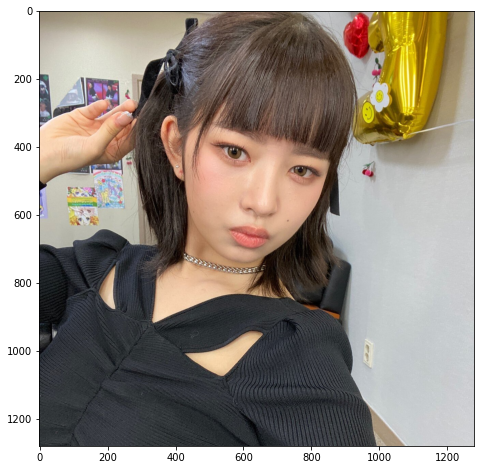

In [5]:
img_path = os.getcwd()+'/images/img.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
segvalues, output = model.segmentAsPascalvoc(img_path)

모델에서 나온 출력값을 확인해보면 아래와 같다.

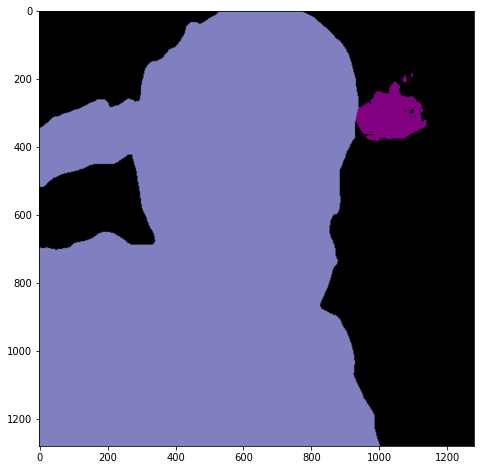

In [7]:
plt.figure(figsize=(8,8))
plt.imshow(output)
plt.show()

In [8]:
segvalues

{'class_ids': array([ 0,  5, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]])}

In [9]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
bottle
person


벽에 걸린 풍선을 물병으로 잘못 분류했음을 알 수 있다.  
이번 프로젝트에는 사람만 필요하므로 이는 무시하도록 한다. 


output이미지에서 확인했던 물체들이 어떤 색깔로 나타나는지 알아보자.

In [10]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

사람에 해당하는 15번의 컬러를 아래와 같다.

In [11]:
colormap[15]  # 사람은 15번

array([192, 128, 128])

위의 결과는 RGB 순서이다. 이를 openCV에서 사용할 것이므로 BGR 순서로 써준다.

In [12]:
# RGB 결과롤 BGR 결과로 써줌
seg_color = (128,128,192)

(1280, 1280)


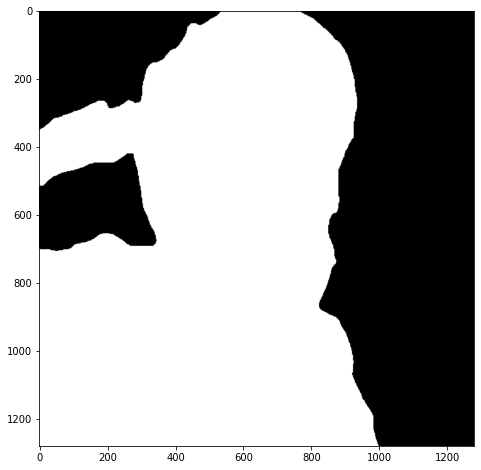

In [13]:
seg_map = np.all(output==seg_color, axis=-1)  #seg_color와 모두 같으면 true, 하나라도 다르면 false
print(seg_map.shape)

plt.figure(figsize=(8,8))
plt.imshow(seg_map, cmap='gray')
plt.show()

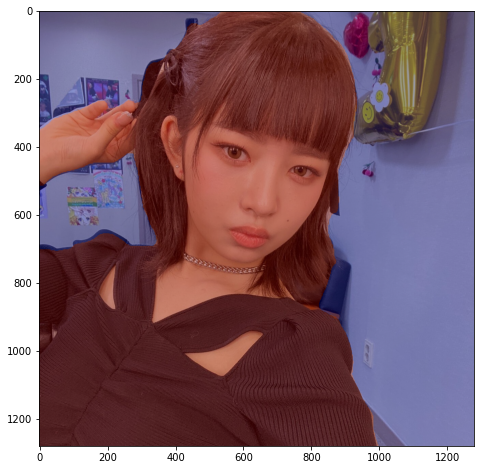

In [14]:
img_show = img_orig.copy()

# 1과 0인 값(true/false)을 각각 255과 0(흑백)으로 바꿔준다.
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔준다.
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 합쳐보자.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

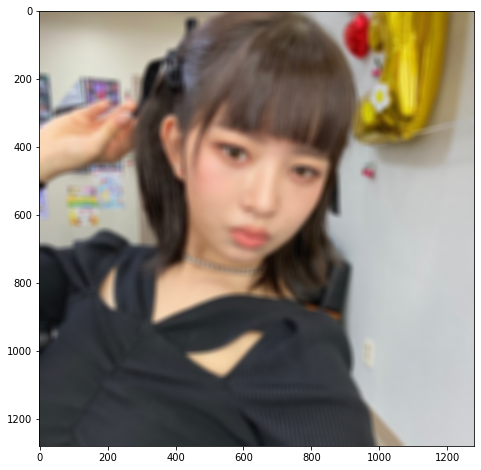

In [15]:
# 배경 흐리게
img_orig_blur = cv2.blur(img_orig, (20,20))  # 20*20 범위 내 픽셀들을 평균 블러링

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

앞선 과정에서 구한 마스크 이미지는 인물이 흰색이고 배경이 까만색이었는데 이를 반전시켜 배경 추출에 이용해보자.

* 반전시키는 이유?  
  흐릿한 배경과 마스크 이미지를 and 연산을 통해 합치는데 인물 부분을 제외하고 배경만 추출하기 위해서는 인물에 해당하는 픽셀값이 0이어야 한다.

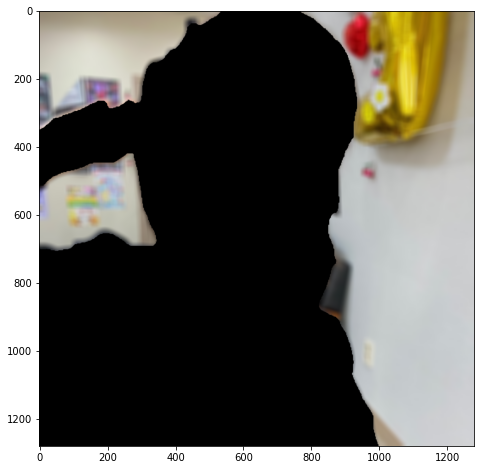

In [16]:
#흐린 배경만 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color) # 마스크 반전
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

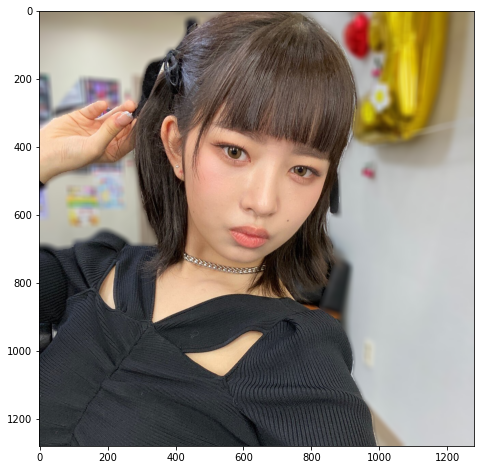

In [17]:
# 흐린 배경 + 인물
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

cv2.imwrite('./images/output/person_focus.jpg', img_concat)

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

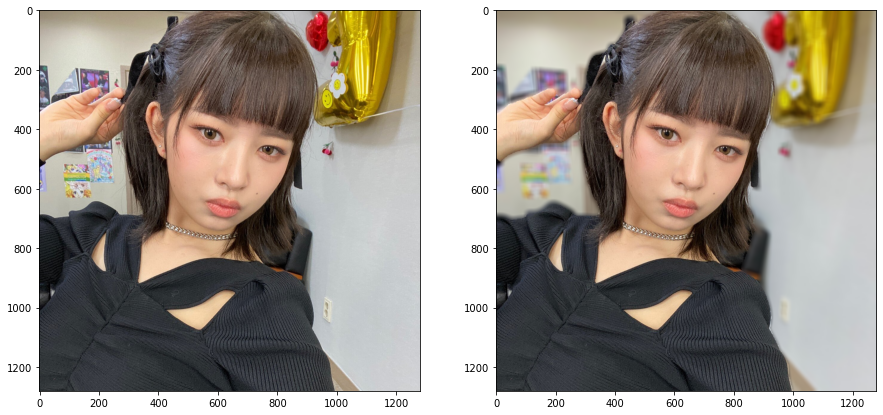

In [18]:
# 원본과 비교
plt.figure(figsize=(15,15))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))

plt.show()

## 2. 고양이 아웃포커싱

1번의 과정과 동일하다.  
다만, colormap에서 고양이에 해당하는 8번 컬러를 사용한다.

(2681, 2681, 3)


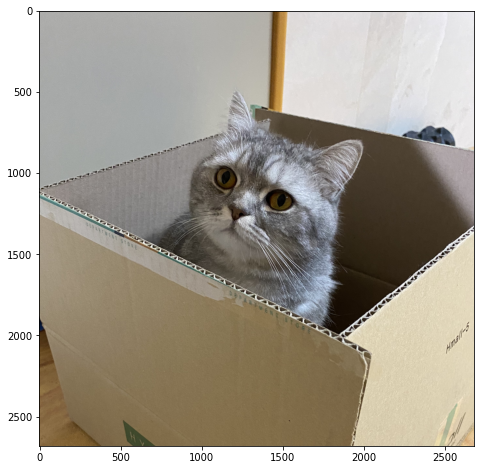

In [19]:
img_path = os.getcwd()+'/images/my_cat.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [20]:
segvalues, output = model.segmentAsPascalvoc(img_path)

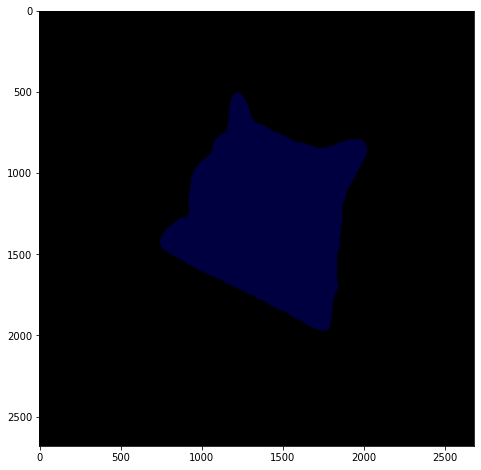

In [21]:
plt.figure(figsize=(8,8))
plt.imshow(output)
plt.show()

In [22]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat


In [23]:
colormap[8]   #고양이는 8번

array([64,  0,  0])

In [24]:
seg_color = (0,0,64)

(2681, 2681)


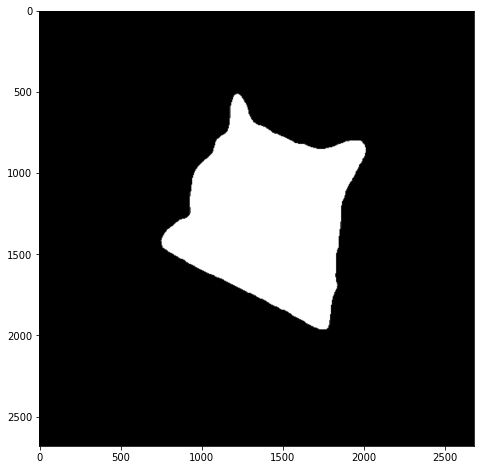

In [25]:
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)

plt.figure(figsize=(8,8))
plt.imshow(seg_map, cmap='gray')
plt.show()

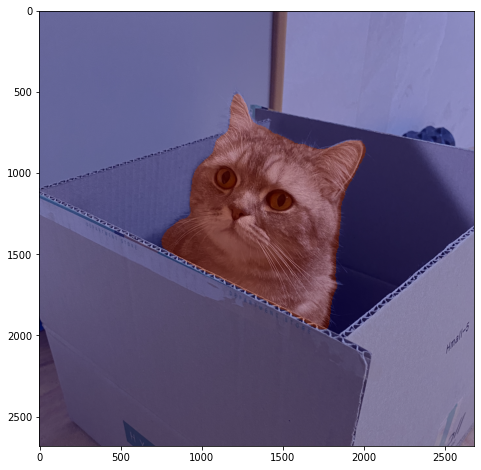

In [26]:
img_show = img_orig.copy()

img_mask = seg_map.astype(np.uint8) * 255

color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

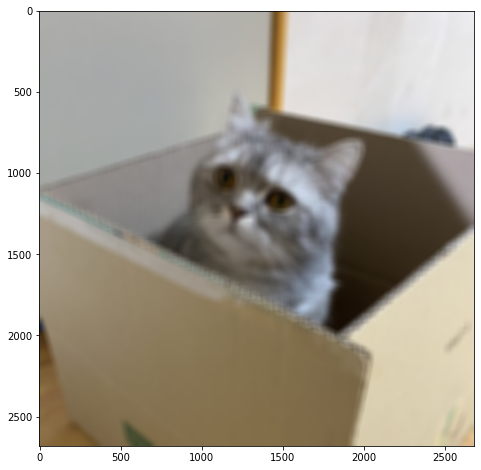

In [27]:
# 배경 흐리게
img_orig_blur = cv2.blur(img_orig, (50,50))  # 확실한 블러링 효과를 위해 커널 크기를 키워준다.

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

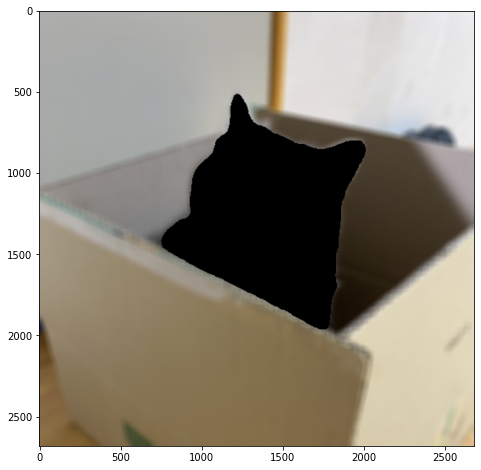

In [28]:
#흐린 배경만 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color) # 마스크 반전
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

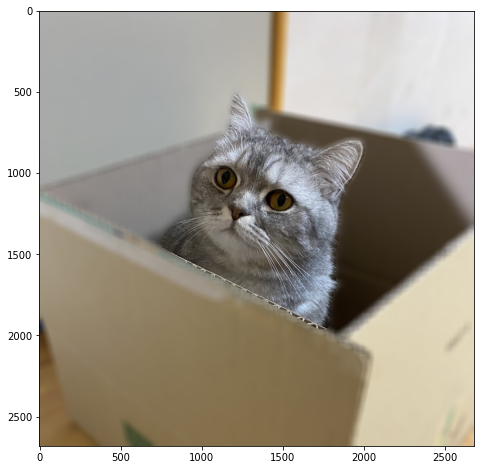

In [29]:
# 흐린 배경 + 고양이
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

cv2.imwrite('./images/output/myCat_focus.jpg', img_concat)

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

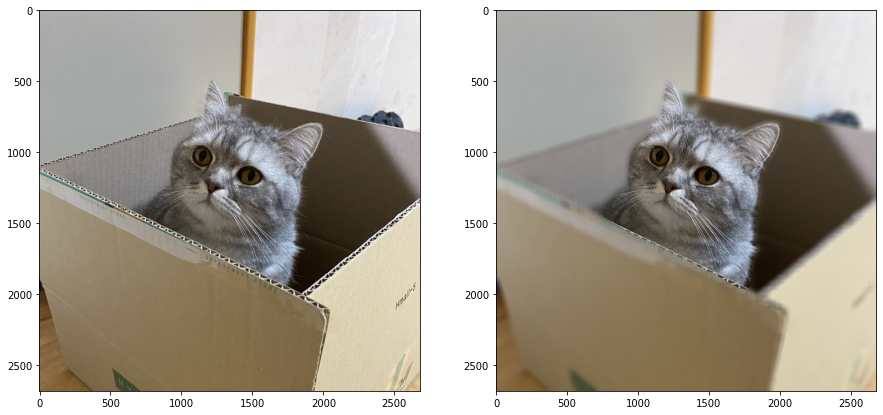

In [30]:
# 원본과 비교
plt.figure(figsize=(15,15))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))

plt.show()

## 3. 크로마키 사진(배경 합성)

위와 동일한 과정으로 인물을 추출한 후 새로운 배경에 합성해보자.

(450, 450, 3)
(1080, 1920, 3)


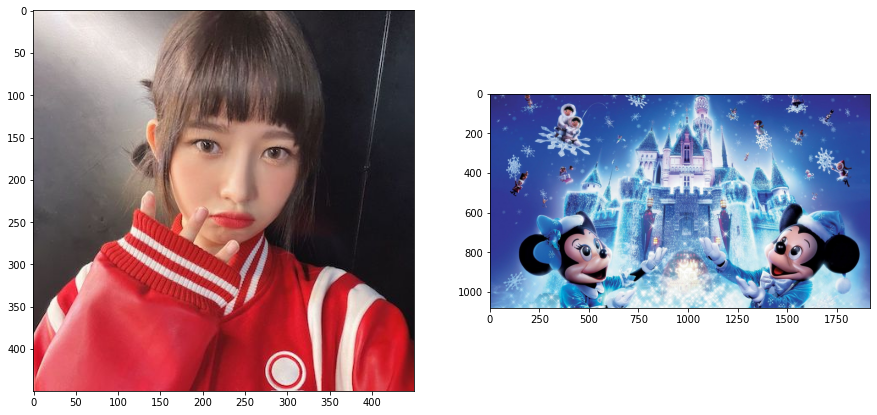

In [31]:
img_path = os.getcwd()+'/images/img2.jpg'  
img_orig = cv2.imread(img_path) 

bg_img_path = os.getcwd()+'/images/bg.jpg'
bg_img_orig = cv2.imread(bg_img_path)

print(img_orig.shape)
print(bg_img_orig.shape)

plt.figure(figsize=(15,15))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(bg_img_orig, cv2.COLOR_BGR2RGB))

plt.show()

In [32]:
segvalues, output = model.segmentAsPascalvoc(img_path)

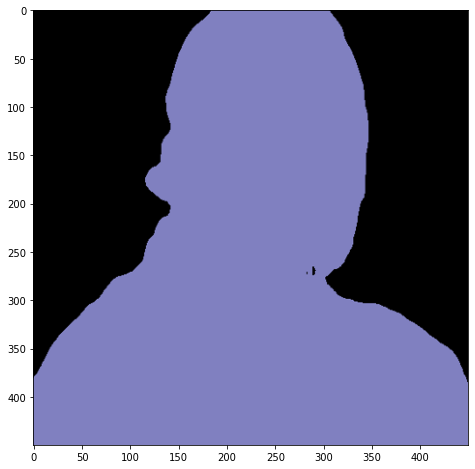

In [33]:
plt.figure(figsize=(8,8))
plt.imshow(output)
plt.show()

In [34]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [35]:
colormap[15]

array([192, 128, 128])

In [36]:
seg_color = (128,128,192)

(450, 450)


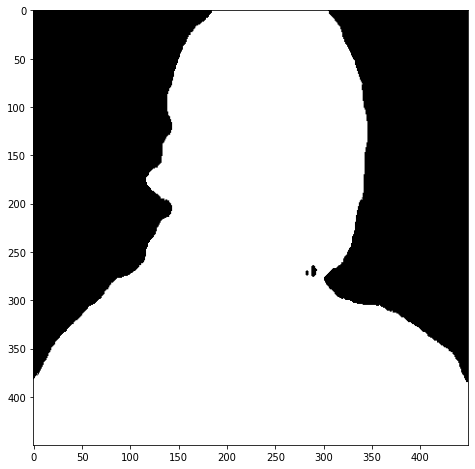

In [37]:
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)

plt.figure(figsize=(8,8))
plt.imshow(seg_map, cmap='gray')
plt.show()

인물은 흰색, 배경은 까만색인 마스크를 이용하여 원본 이미지와 and 연산을 수행하면 인물만 추출할 수 있다.

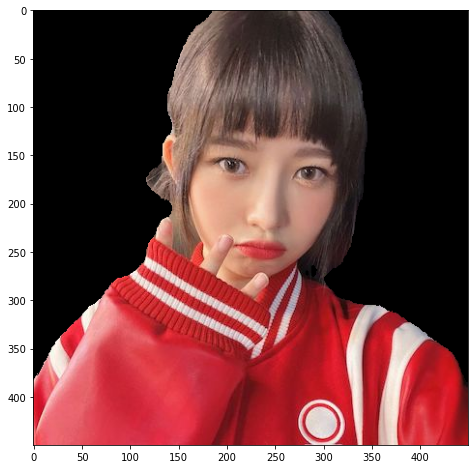

In [38]:
# 인물만 추출
img_mask = seg_map.astype(np.uint8) * 255
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_ex = cv2.bitwise_and(img_orig, img_mask_color)

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_ex, cv2.COLOR_BGR2RGB))
plt.show()

추출된 인물 사진을 배경사진에서 합성할 위치를 정한다.  
미키마우스와 미니마우스 사이에 인물을 위치시키고자 한다.

In [39]:
# 인물이 합성될 위치
roi = bg_img_orig[630:630+img_orig.shape[0],735:735+img_orig.shape[1]]

roi.shape

(450, 450, 3)

3번 노드인 스티커 붙이기에서 사용했던 방법을 이용하여 합성을 한다.

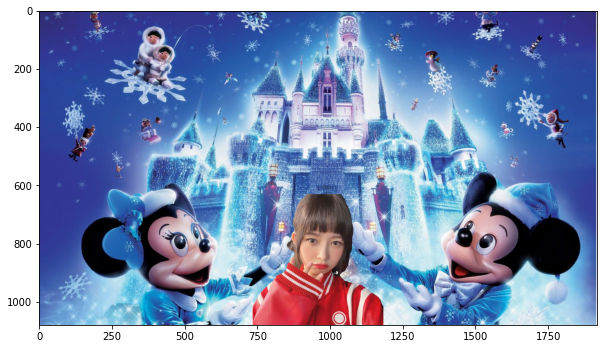

In [40]:
bg_img_orig[630:630+img_orig.shape[0],735:735+img_orig.shape[1]]= \
    np.where(img_ex==0,roi,img_ex).astype(np.uint8)

cv2.imwrite('./images/output/chromaKey.jpg', bg_img_orig)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(bg_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## 4. 문제점 및 솔루션

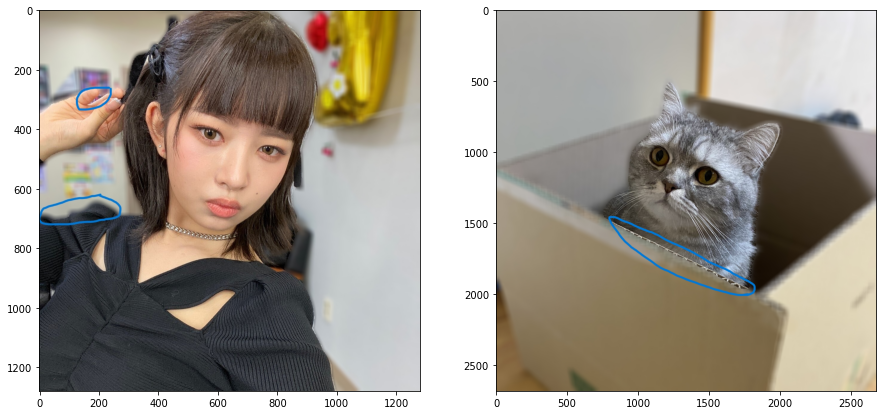

In [41]:
img_path = './images'  
p1 = cv2.imread(img_path + '/problem1.jpg') 
p2 = cv2.imread(img_path + '/problem2.jpg')

plt.figure(figsize=(15,15))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(p1, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(p2, cv2.COLOR_BGR2RGB))

plt.show()

사람, 고양이 상관 없이 결과물의 경계가 부자연스럽다. 거기에 추가적으로 각 이미지 마다 또 다른 문제점들이 있었다.  
첫번째 사진의 경우 옷 부분을 사람이라고 인식하지 못했고, 손가락 사이로 비치는 배경을 구분하지 못했다.  
두번째 사진은 고양이와 박스의 경계를 제대로 구분하지 못해 박스의 일부까지 고양이로 인식하였다.  
이 같은 문제점은 어떻게 해결해야 할까?

###  - 블러링 방식 변경

배경을 블러링할 때 평균 블러링이 아니라 엣지를 살려주는 가우시안 블러링을 사용해보겠다.  
또한 마스크 이미지도 블러 처리를 하여 경계가 자연스럽게 이어지게 해보자.

In [42]:
file_path = './images/img.jpg'

img_orig = cv2.imread(file_path)

In [43]:
segvalues, output = model.segmentAsPascalvoc(file_path)
    
# 마스크 추출
seg_color = colormap[15][::-1]

seg_map = np.all(output==seg_color, axis=-1)

img_mask = seg_map.astype(np.uint8) * 255
img_mask = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_mask = cv2.bitwise_not(img_mask) # 마스크 반전

print(img_mask.shape)
print(img_orig.shape)

(1280, 1280, 3)
(1280, 1280, 3)


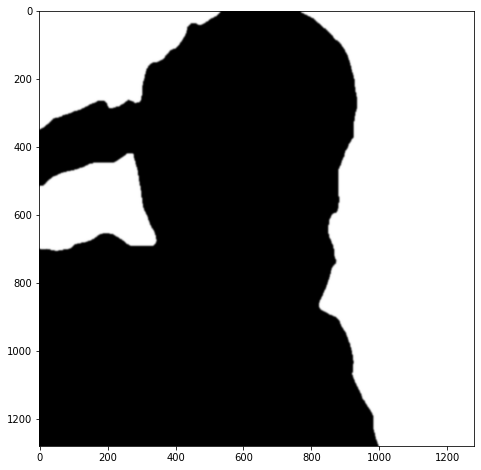

In [44]:
# 마스크 가우시안 블러링
img_mask_blur = cv2.GaussianBlur(img_mask, (0, 0), 2, 2)

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_mask_blur, cv2.COLOR_BGR2RGB))
plt.show()

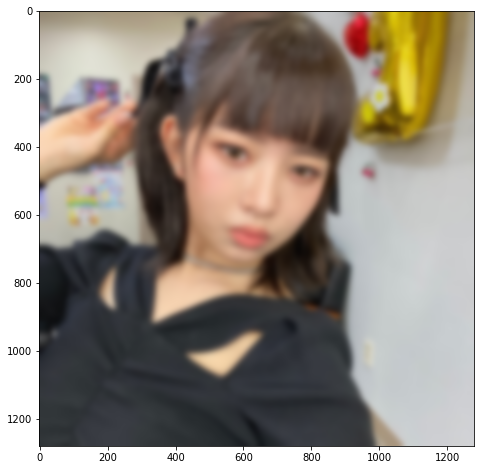

In [45]:
# 원본 이미지 가우시안 블러링
img_orig_blur = cv2.GaussianBlur(img_orig, (55,55), 0)

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

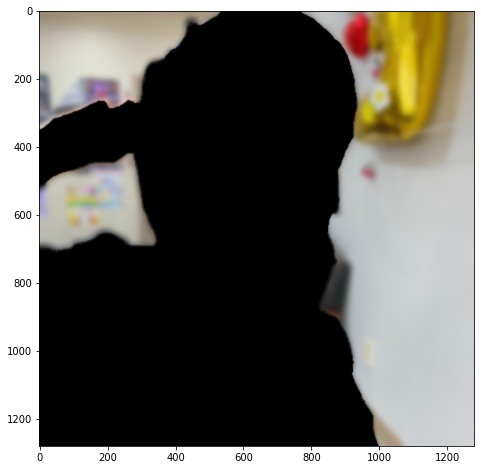

In [46]:
# 블러링 마스크 + 블러링 배경
img_bg_mask_blur = cv2.bitwise_and(img_mask_blur, img_orig_blur)

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_bg_mask_blur, cv2.COLOR_BGR2RGB))
plt.show()

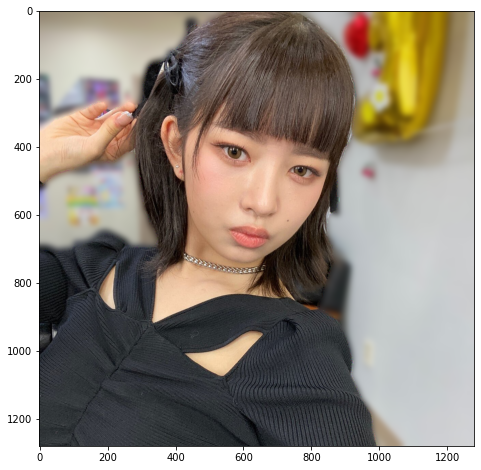

In [47]:
# 결과 이미지
img_concat = np.where(img_bg_mask_blur==0, img_orig, img_orig_blur)

cv2.imwrite('./images/output/Gblur.jpg', img_concat)

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

이전보다 경계는 부드러워졌지만 모델이 인식하는 인물의 범위는 그대로이므로 그 외의 문제점은 해결하지 못했다.  
나머지 문제점은 어떻게 해결하면 좋을까?

### - 솔루션 제안

- 세그멘테이션 모델 변경
  근본적으로 모델이 인식하는 객체의 경계가 완벽하지 않으면 정확한 인물사진을 만들 수 없다.  
  모델 자체를 변경하여 더 좋은 결과를 얻을 수 있을 것 같다.
  

- 추가적인 센서 사용
  LiDAR, 3D Camera, 적외선 센서 등을 사용하여 사진을 취득할 때부터 아웃포커싱이 된 사진을 얻을 수 있다. 

### 

## 5. 회고

#### 문제 해결의 어려움

그동안은 기준을 만족시킨 결과물만 만들어내면 됐지만 이번 노드에서는 결과물에 대한 전반적인 문제점에 대해 분석하고 해결해야 했기 때문에 어려움을 많이 느꼈다.  모델을 변경하는 솔루션은 실제로 구현해보고 싶었으나 적용에 실패하였다. 시간의 여유가 있으면 반드시 구현을 해보고 싶다.


#### CV 분야의 흥미

결과를 중간중간 눈으로 직접 보면서 수정이 가능하기 때문에 조금씩 바꾸어가며 변화를 보는 것이 재미있다고 느꼈다.  



## 6. 참고 자료

- 여러가지 블러링  
  https://webnautes.tistory.com/1255